In [72]:
import numpy as np
import time
import progressbar
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import SimpleITK as sitk
import scipy.misc as misc
import scipy.ndimage as snd
import imageio
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import h5py
%matplotlib inline

In [4]:
x = h5py.File('/home/ryan/ImageSegmentationMedical/data/2DLiverSlices_128.h5','r')
images = x['image'][:]
labels = x['label'][:]
x.close

<bound method File.close of <HDF5 file "2DLiverSlices_128.h5" (mode r)>>

In [5]:
print(labels.shape)
print(images.shape)


(2000, 128, 128)
(2000, 128, 128)


In [6]:
train_images = images[:1500]
train_labels = labels[:1500]
val_images = images[1500:]
val_labels = labels[1500:] 

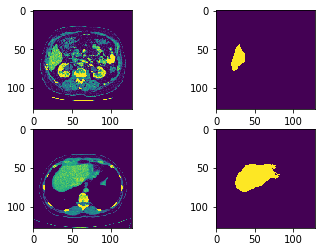

In [7]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(train_images[0])

plt.subplot(2,2,2)
plt.imshow(train_labels[0])
plt.subplot(2,2,3)
plt.imshow(val_images[10])

plt.subplot(2,2,4)
plt.imshow(val_labels[10])


In [73]:
class UNet(nn.Module):
    
    def __init__(self):
        
        super(UNet, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.conv3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128))
        
        self.upconv1 = nn.Sequential(nn.ConvTranspose2d(128,128,stride=2, kernel_size=2), nn.BatchNorm2d(128))
        self.conv5 = nn.Sequential(nn.Conv2d(128,64, kernel_size=3, padding=1), nn.BatchNorm2d(64))
        
        self.upconv2 = nn.Sequential(nn.ConvTranspose2d(128,32,stride=2, kernel_size=2), nn.BatchNorm2d(32))
        self.conv6 = nn.Sequential(nn.Conv2d(32,2, kernel_size=3, padding=1), nn.BatchNorm2d(2))
        
    def forward(self, x):
        
        x = F.relu(self.conv2(F.relu(self.conv1(x))), inplace=True)
        x_0 = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv4(F.relu(self.conv3(x_0))), inplace=True)
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv5(F.relu(self.upconv1(x))))
        x = torch.cat([x,x_0], 1)
        x = self.conv6(F.relu(self.upconv2(x)))
        x = F.log_softmax(x, dim=1)
        
        return x

In [74]:
class SimpleTrainer(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        
    def forward_backward(self,inputs, labels):
        self.inputs = inputs
        self.labels = labels
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs) #.cuda()
        labels = Variable(labels) #.cuda()
        self.optimizer.zero_grad()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def forward(self ,inputs, labels):
        inputs = torch.from_numpy(inputs).float()
        labels = torch.from_numpy(labels).long()
        inputs = Variable(inputs, volatile=True) #.cuda()
        labels = Variable(labels, volatile=True) #.cuda()
        outputs = self.model.forward(inputs)
        loss = self.loss_fn(outputs, labels)
        return loss.item()

In [75]:
EPOCHS = 100  # Number of iterations for training the newtork
BATCH_SIZE = 48  # Number of training example to be fed to the network
PATCH_SIZE = [128,128]  # the input size of the image (L*B)

In [76]:
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=5e-5)
trainer = SimpleTrainer(model,nn.NLLLoss2d(), optimizer) 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:210: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


In [22]:
# label_batch.shape
# image_batch[0]

In [24]:
for i in range(EPOCHS):
    print('Epoch: ' + str(i))
    
    # train
    model.train()
    train_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, train_images.shape[0], BATCH_SIZE)):
        
        image_batch, label_batch = train_images[j: j+BATCH_SIZE], train_labels[j: j+BATCH_SIZE]
        
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        
        train_loss.append(trainer.forward_backward(image_batch, label_batch))
        
    print('Train loss: ' + str(np.array(train_loss).mean()))
    
    torch.save({'state_dict':model.cpu().float().state_dict()}, 'conv-deconv_cputest.tar')
    model #.cuda()
    # validate
    
    model.eval()    
    val_loss = []
    bar = progressbar.ProgressBar()
    for j in bar(range(0, val_images.shape[0], BATCH_SIZE)):
        image_batch, label_batch = val_images[j: j+BATCH_SIZE], val_labels[j: j+BATCH_SIZE]
        image_batch = image_batch.reshape(image_batch.shape[0], 1, PATCH_SIZE[0], PATCH_SIZE[1])
        val_loss.append(trainer.forward(image_batch, label_batch))
    print('Val loss: ' + str(np.array(val_loss).mean()))

Epoch: 0


100% |########################################################################|
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Train loss: 0.48186484072357416


100% |########################################################################|


Val loss: 0.4482760022987019
Epoch: 1


100% |########################################################################|


Train loss: 0.4621608192101121


100% |########################################################################|


Val loss: 0.4247077595103871
Epoch: 2


KeyboardInterrupt: 

In [77]:
state = torch.load('/home/ryan/ImageSegmentationMedical/data/pertained_models/u-net_cpu.tar')['state_dict']
model = UNet() #.cuda()
model.load_state_dict(state)


<All keys matched successfully>

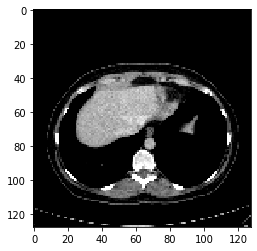

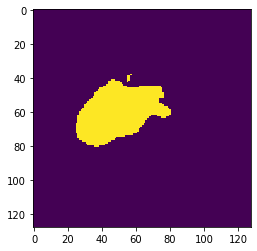

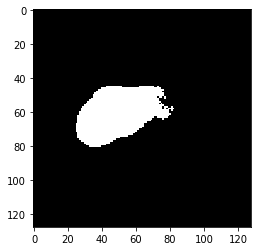

In [30]:

model.eval()
inputs = Variable(torch.from_numpy(val_images[4].reshape(1,1,128,128))) #.cuda()
out = model.forward(inputs)
out = np.argmax(out.data.cpu().numpy(), axis=1).reshape(128,128)
plt.figure()
plt.imshow(val_images[4], cmap = 'gray')
plt.figure()
plt.imshow(out)
plt.figure()
plt.imshow(val_labels[4],cmap = 'gray')

In [78]:
def display_image_label_and_output(image, label, output):
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(image, cmap = 'gray')
    plt.subplot(1,3,2)
    plt.imshow(image, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.subplot(1,3,3)
    plt.imshow(output, cmap = 'gray')
    plt.imshow(label, alpha = 0.5)
    plt.show()    

In [88]:
def predict(model , image , label):
        inputs = Variable(torch.from_numpy(image.reshape(1,1,128,128))) #.cuda()
        inputs = inputs.float()
        out = model.forward(inputs)
        out = np.argmax(out.data.cpu().numpy(), axis=1).reshape(128,128)
        display_image_label_and_output(image, label, out)

In [91]:
img_arr = imageio.imread('/home/ryan/ImageSegmentationMedical/data/test_images/img3.png')

label_arr = imageio.imread('/home/ryan/ImageSegmentationMedical/data/test_images/label3.png')

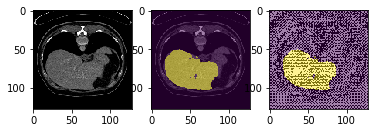

In [92]:
predict(UNet() , img_arr ,label_arr)